<a href="https://colab.research.google.com/github/sarvadutt/Exploring-Gene-Expression-Landscapes-A-Deep-Autoencoder-Approach/blob/main/geno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin


##Reading the data file

In [ ]:
df = pd.read_csv("GSE183947_fpkm.csv")
df.head()

,Unnamed: 0,CA.102548,CA.104338,CA.105094,CA.109745,CA.1906415,CA.1912627,CA.1924346,CA.1926760,CA.1927842,...,CAP.2040686,CAP.2046297,CAP.2046641,CAP.348981,CAP.354300,CAP.359448,CAP.94377,CAP.98389,CAP.98475,CAP.99145
0,TSPAN6,0.93,1.97,0.00,5.45,4.52,4.75,3.96,3.58,6.41,...,6.66,8.35,8.94,6.33,5.94,6.35,3.74,4.84,10.46,4.54
1,TNMD,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.23,0.39,...,0.12,0.17,1.08,0.29,0.00,0.07,9.19,1.18,0.09,0.39
2,DPM1,0.00,0.43,0.00,3.43,8.45,8.53,7.80,7.62,6.40,...,4.93,7.47,5.72,4.96,9.28,9.15,4.77,3.75,7.31,2.77
3,SCYL3,5.78,5.17,8.76,4.58,7.20,6.03,9.05,5.37,5.92,...,8.02,6.00,5.28,4.98,4.45,7.00,4.14,5.51,7.45,2.33
4,C1orf112,2.83,6.26,3.37,6.24,5.16,13.69,6.69,5.28,7.65,...,7.91,4.61,8.35,9.84,7.68,5.62,2.81,7.08,7.28,5.39


## Changing objects type to integrate

In [ ]:

def convert_object_to_integer_with_mapping(df, column_name):
    # Create a mapping between original values and unique integers
    value_mapping = {value: index for index, value in enumerate(df[column_name].unique())}


    df[column_name] = df[column_name].map(value_mapping)

column_to_convert = "Unnamed: 0"


convert_object_to_integer_with_mapping(df, column_to_convert)

df.head()

,Unnamed: 0,CA.102548,CA.104338,CA.105094,CA.109745,CA.1906415,CA.1912627,CA.1924346,CA.1926760,CA.1927842,...,CAP.2040686,CAP.2046297,CAP.2046641,CAP.348981,CAP.354300,CAP.359448,CAP.94377,CAP.98389,CAP.98475,CAP.99145
0,0,0.93,1.97,0.00,5.45,4.52,4.75,3.96,3.58,6.41,...,6.66,8.35,8.94,6.33,5.94,6.35,3.74,4.84,10.46,4.54
1,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.23,0.39,...,0.12,0.17,1.08,0.29,0.00,0.07,9.19,1.18,0.09,0.39
2,2,0.00,0.43,0.00,3.43,8.45,8.53,7.80,7.62,6.40,...,4.93,7.47,5.72,4.96,9.28,9.15,4.77,3.75,7.31,2.77
3,3,5.78,5.17,8.76,4.58,7.20,6.03,9.05,5.37,5.92,...,8.02,6.00,5.28,4.98,4.45,7.00,4.14,5.51,7.45,2.33
4,4,2.83,6.26,3.37,6.24,5.16,13.69,6.69,5.28,7.65,...,7.91,4.61,8.35,9.84,7.68,5.62,2.81,7.08,7.28,5.39


##spliting th dataset into test and train

In [ ]:
train,test = np.split(df.sample(frac=1), [int(0.8*len(df))])

In [ ]:

def preprocess_data(dataframe):
    # Extract input features (X) and target variable (Y)
    input_columns = dataframe.columns.difference(['Unnamed: 0']).tolist()
    X = dataframe[input_columns]
    Y = dataframe['Unnamed: 0']
    # Handle missing values
    X = X.dropna()  # Drop rows with NaN values
    # Reshape X to (number of samples, -1)
    reshaped_array = np.reshape(X, (X.shape[0], -1))
    X = np.hstack((X, reshaped_array))

    # Standardize input features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    return X, Y



In [ ]:
X_train,Y_train = preprocess_data(train)


X_test,Y_test = preprocess_data(test)

## initializing Autoencoder

In [ ]:


# Assuming 60 features in your input data
original_data_dimension = 120


# Define the size of the encoded representation
encoding_dim = 30  # Adjust based on your preference

# Input layer
input_data = Input(shape=(original_data_dimension,))

# Encoder layers
encoded = Dense(encoding_dim, activation='relu')(input_data)

# Decoder layers
decoded = Dense(original_data_dimension, activation='sigmoid')(encoded)

# Autoencoder model
autoencoder = Model(input_data, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')  # Using mean squared error as loss, adjust based on your problem

# Train the autoencoder on your training data
autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_test, X_test))


Epoch 1/50
64/64 [==============================] - 1s 6ms/step - loss: 1.1915 - val_loss: 0.9580
Epoch 2/50
64/64 [==============================] - 0s 3ms/step - loss: 1.0380 - val_loss: 0.8973
Epoch 3/50
64/64 [==============================] - 0s 3ms/step - loss: 0.9978 - val_loss: 0.8875
Epoch 4/50
64/64 [==============================] - 0s 3ms/step - loss: 0.9858 - val_loss: 0.8808
Epoch 5/50
64/64 [==============================] - 0s 3ms/step - loss: 0.9768 - val_loss: 0.8772
Epoch 6/50
64/64 [==============================] - 0s 3ms/step - loss: 0.9702 - val_loss: 0.8730
Epoch 7/50
64/64 [==============================] - 0s 4ms/step - loss: 0.9647 - val_loss: 0.8690
Epoch 8/50
64/64 [==============================] - 0s 3ms/step - loss: 0.9599 - val_loss: 0.8649
Epoch 9/50
64/64 [==============================] - 0s 3ms/step - loss: 0.9563 - val_loss: 0.8617
Epoch 10/50
64/64 [==============================] - 0s 3ms/step - loss: 0.9543 - val_loss: 0.8594
Epoch 11/50
64/64 [

##Calculating Loss value

In [ ]:
# Reconstruct the test data
reconstructed_test_data = autoencoder.predict(X_test)

# Evaluate the performance (e.g., using mean squared error)
evaluation_loss = np.mean(np.square(X_test - reconstructed_test_data))
print("Evaluation Loss on Test Data:", evaluation_loss)


127/127 [==============================] - 0s 2ms/step
Evaluation Loss on Test Data: 0.8275691560339808


##Visualizing Prediction

1/1 [==============================] - 0s 33ms/step


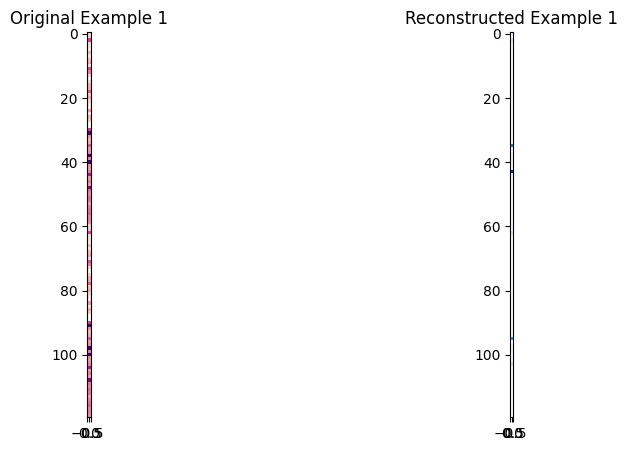

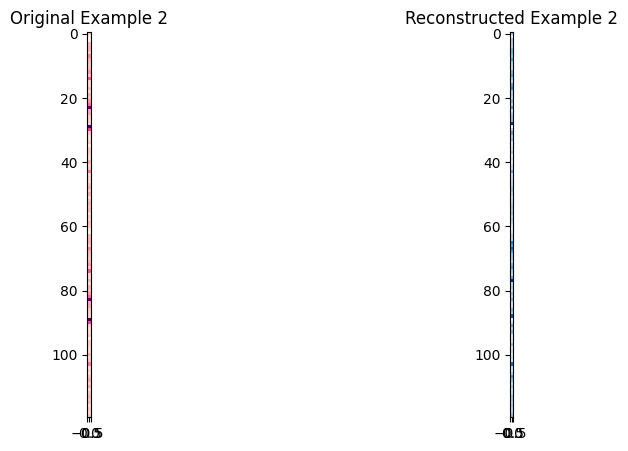

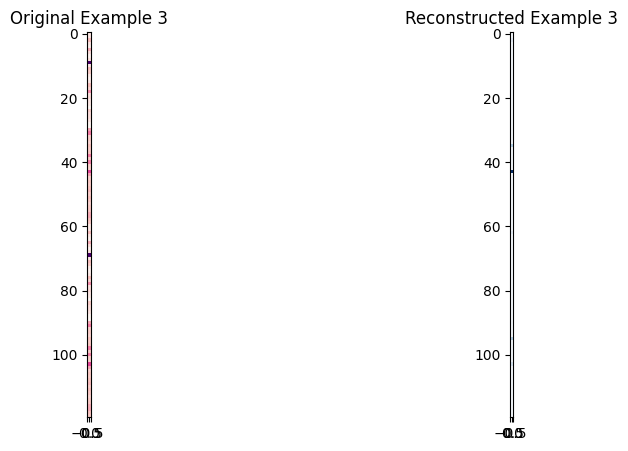

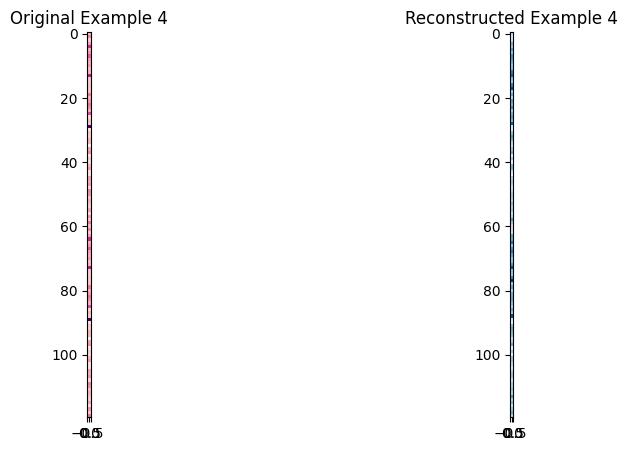

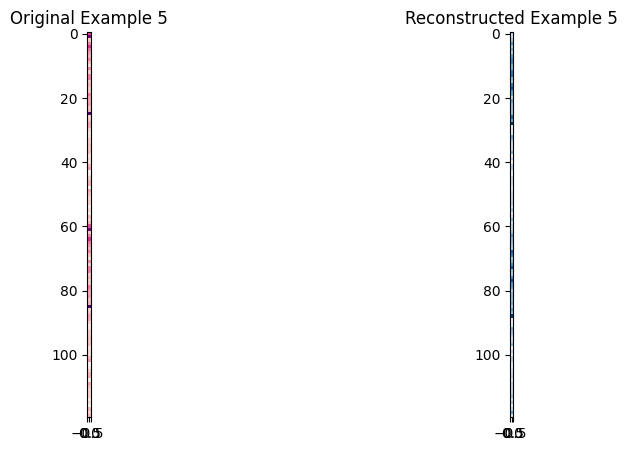

In [ ]:


# Choose a random subset of data for visualization
num_examples_to_visualize = 5
random_indices = np.random.choice(len(X_test), num_examples_to_visualize, replace=False)

# Reconstruct the chosen examples
reconstructed_examples = autoencoder.predict(X_test[random_indices])

# Plot the original and reconstructed examples
for i in range(num_examples_to_visualize):
    plt.figure(figsize=(10, 5))

    # Original data
    plt.subplot(1, 2, 1)
    plt.title('Original Example {}'.format(i + 1))
    plt.imshow(X_test[random_indices[i]].reshape(original_data_dimension, -1), cmap='RdPu')

    # Reconstructed data
    plt.subplot(1, 2, 2)
    plt.title('Reconstructed Example {}'.format(i + 1))
    plt.imshow(reconstructed_examples[i].reshape(original_data_dimension, -1), cmap='Blues')

    plt.show()


##Checking Hyperparameters and getting best parameters

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator

# Function to create and compile the autoencoder model
def create_autoencoder(encoding_dim, layer1_units=64, layer2_units=32):
    model = Sequential()
    model.add(Dense(layer1_units, activation='relu', input_shape=(original_data_dimension,)))
    model.add(Dense(layer2_units, activation='relu'))
    model.add(Dense(encoding_dim, activation='relu'))
    model.add(Dense(layer2_units, activation='relu'))
    model.add(Dense(layer1_units, activation='relu'))
    model.add(Dense(original_data_dimension, activation='sigmoid'))
    model.compile(optimizer='adam', loss='mse')
    return model

# Custom estimator class to use in GridSearchCV
class AutoencoderEstimator(BaseEstimator):
    def __init__(self, encoding_dim, layer1_units=64, layer2_units=32, epochs=50, batch_size=256, verbose=0):
        self.encoding_dim = encoding_dim
        self.layer1_units = layer1_units
        self.layer2_units = layer2_units
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model = create_autoencoder(encoding_dim, layer1_units, layer2_units)

    def fit(self, X, y=None):
        self.model.fit(X, X, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)
        return self

    def predict(self, X):
        return self.model.predict(X)

# Define the parameter grid
param_grid = {
    'encoding_dim': [10, 20, 30],  # Adjust based on your preference
    'layer1_units': [32, 64, 128],  # Number of units in the first hidden layer
    'layer2_units': [16, 32, 64]   # Number of units in the second hidden layer
}

# Define a scoring function (e.g., mean squared error)
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Create the GridSearchCV object
autoencoder = AutoencoderEstimator(encoding_dim=20, epochs=50, batch_size=256, verbose=0)
grid = GridSearchCV(estimator=autoencoder, param_grid=param_grid, scoring=scorer, cv=3)

# Fit the model to the data
grid_result = grid.fit(X_train, X_train)

# Print the best parameters and best score
print("Best Parameters: ", grid_result.best_params_)
print("Best Score: ", grid_result.best_score_)


9/9 [==============================] - 0s 3ms/step
Best Parameters:  {'encoding_dim': 20, 'layer1_units': 32, 'layer2_units': 16}
Best Score:  -0.0702305877379631


##loading the best parameters to the models

In [ ]:
best_params = grid_result.best_params_

# Create the final autoencoder model with the best parameters
final_autoencoder = AutoencoderEstimator(encoding_dim=best_params['encoding_dim'],
                                         layer1_units=best_params['layer1_units'],
                                         layer2_units=best_params['layer2_units'],
                                         epochs=50, batch_size=256, verbose=0)

# Fit the final model to the training data
final_autoencoder.fit(X_train, X_train)

# Make predictions on the test data
predictions = final_autoencoder.predict(X_test)


7/7 [==============================] - 0s 2ms/step


##Visualizing the predictions by best parameters

1/1 [==============================] - 0s 21ms/step


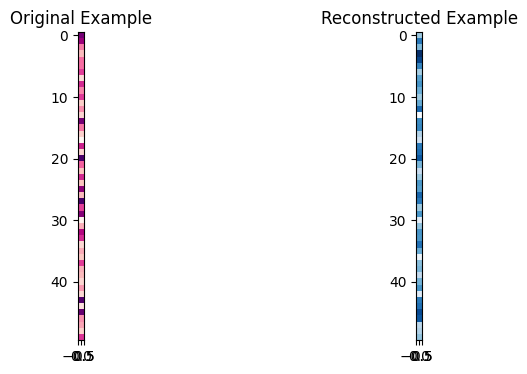

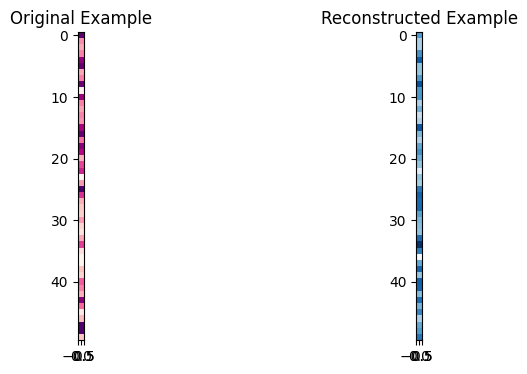

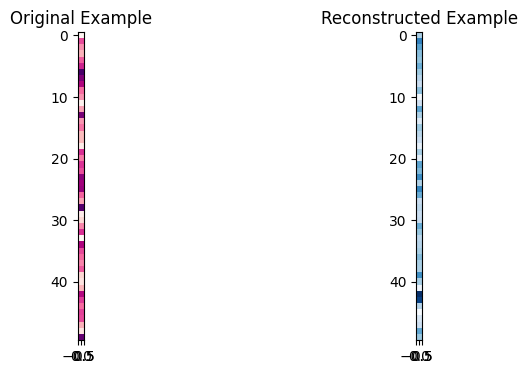

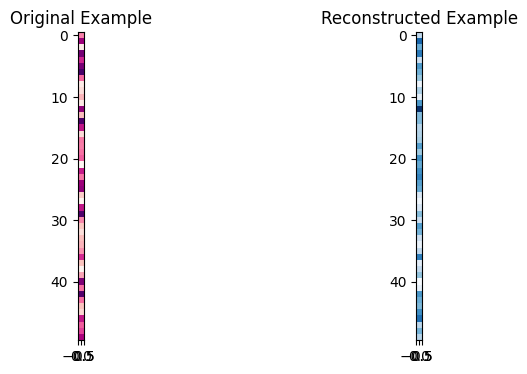

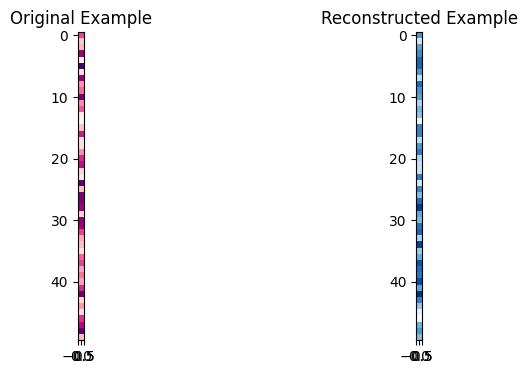

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Select a few examples from the test set
num_examples_to_visualize = 5
selected_indices = np.random.choice(len(X_test), num_examples_to_visualize, replace=False)
selected_examples = X_test[selected_indices]

# Make predictions using the final autoencoder
predicted_examples = final_autoencoder.predict(selected_examples)

# Plot the original and reconstructed examples
for i in range(num_examples_to_visualize):
    plt.figure(figsize=(8, 4))

    # Original example
    plt.subplot(1, 2, 1)
    plt.imshow(selected_examples[i].reshape(original_data_dimension, -1), cmap='RdPu')
    plt.title('Original Example')

    # Reconstructed example
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_examples[i].reshape(original_data_dimension, -1), cmap='Blues')
    plt.title('Reconstructed Example')

    plt.show()


##Calculating MSE for both train and test sets

In [ ]:
from sklearn.metrics import mean_squared_error

# Make predictions on training and test data
train_predictions = final_autoencoder.predict(X_train)
test_predictions = final_autoencoder.predict(X_test)

# Calculate Mean Squared Error
train_mse = mean_squared_error(X_train, train_predictions)
test_mse = mean_squared_error(X_test, test_predictions)

print(f'Training MSE: {train_mse:.4f}')
print(f'Test MSE: {test_mse:.4f}')


7/7 [==============================] - 0s 3ms/step
Training MSE: 0.0880
Test MSE: 0.0855


##finalizing the model and save

In [ ]:
import joblib

# Save the trained model to a file
model_filename = "GSE18.pkl"
joblib.dump(final_autoencoder, model_filename)





['GSE18.pkl']